In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np

torch.set_default_device('cuda')
np.random.seed(1)

import os, sys
m_path = os.path.abspath(os.path.join("..\.."))
if m_path not in sys.path:
    sys.path.append(m_path)

# load data

In [2]:
import pickle
from xcloth.train.data import DataLoader

data_path = "../../data/test_data/"
loader = DataLoader()

loader.load_all(data_path, mask={"88-1"}, excld=False)
loader.stats

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


{'registered pose': 1,
 'registered mesh': 1,
 'common keys': {'88-1'},
 'extra pose': set(),
 'extra mesh': set()}

In [3]:
t = loader.make_tensors(1)
[print(i.shape) for i in t]

torch.Size([1, 1, 4, 512, 512])
torch.Size([1, 1, 3, 512, 512])
torch.Size([1, 1, 4, 512, 512])
torch.Size([1, 1, 4, 3, 512, 512])
torch.Size([1, 1, 4, 3, 512, 512])


[None, None, None, None, None]

In [4]:
X_train, y_train = loader.make_Xy(*t, depth_offset=.5)
print(X_train.shape, [(i, y.shape) for i, y in y_train.items()])

torch.Size([1, 1, 7, 512, 512]) [('Depth', torch.Size([1, 1, 4, 1, 512, 512])), ('Norm', torch.Size([1, 1, 4, 3, 512, 512])), ('RGB', torch.Size([1, 1, 3, 3, 512, 512]))]


In [5]:
b = 0
X_train = X_train[:, b:1+b]
y_train = {i: y[:, b:1+b] for i, y in y_train.items()}
print(X_train.shape, [(i, y.shape) for i, y in y_train.items()])

torch.Size([1, 1, 7, 512, 512]) [('Depth', torch.Size([1, 1, 4, 1, 512, 512])), ('Norm', torch.Size([1, 1, 4, 3, 512, 512])), ('RGB', torch.Size([1, 1, 3, 3, 512, 512]))]


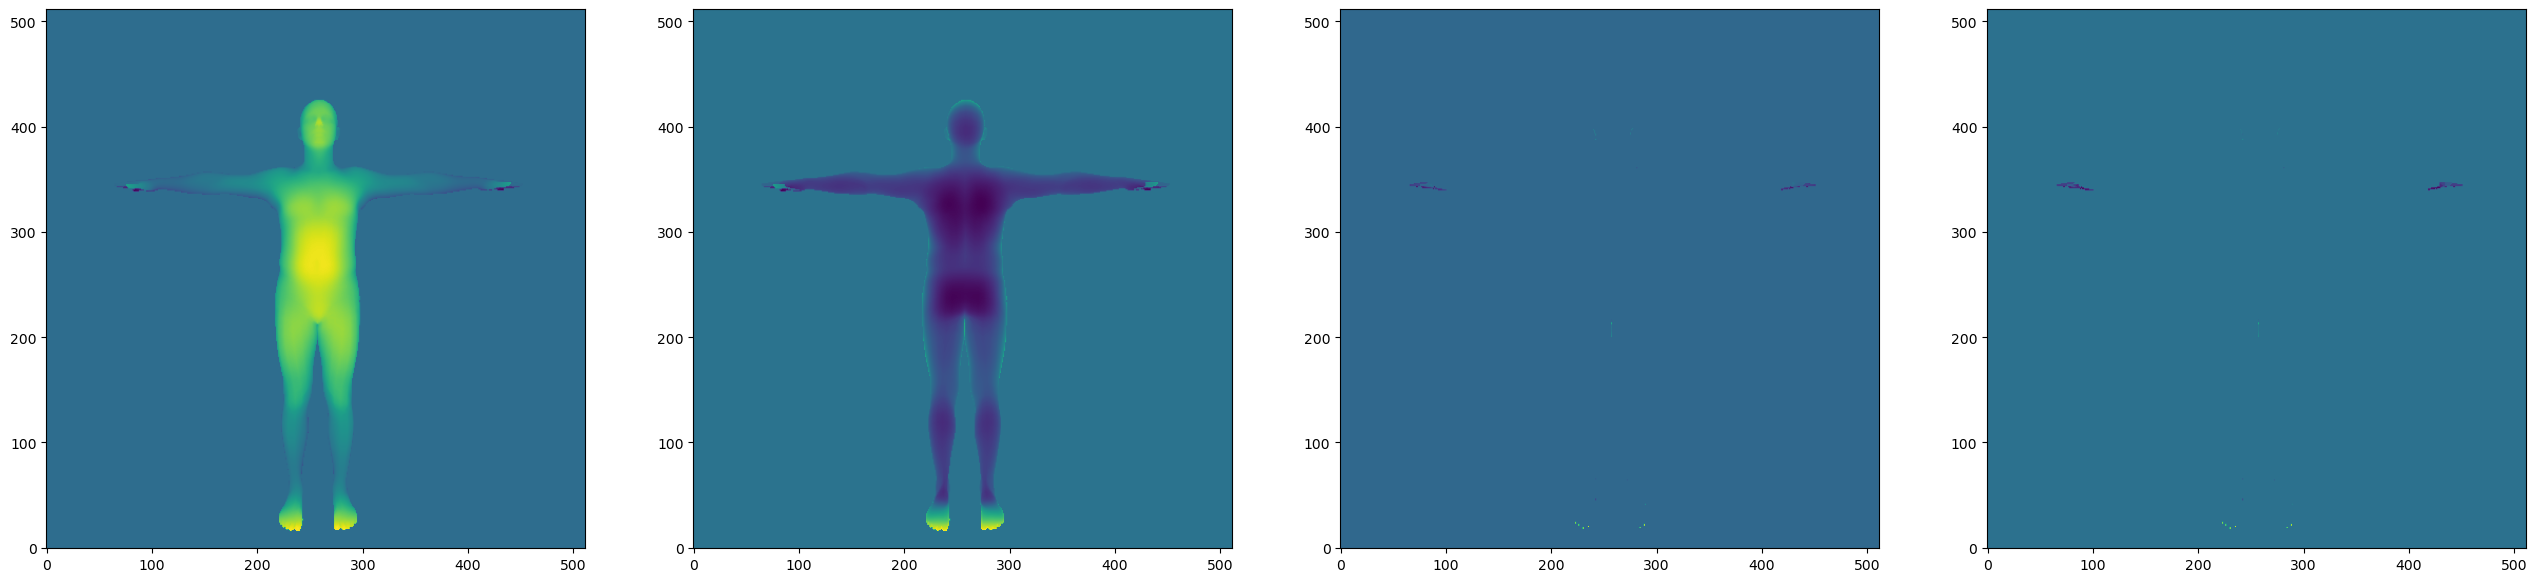

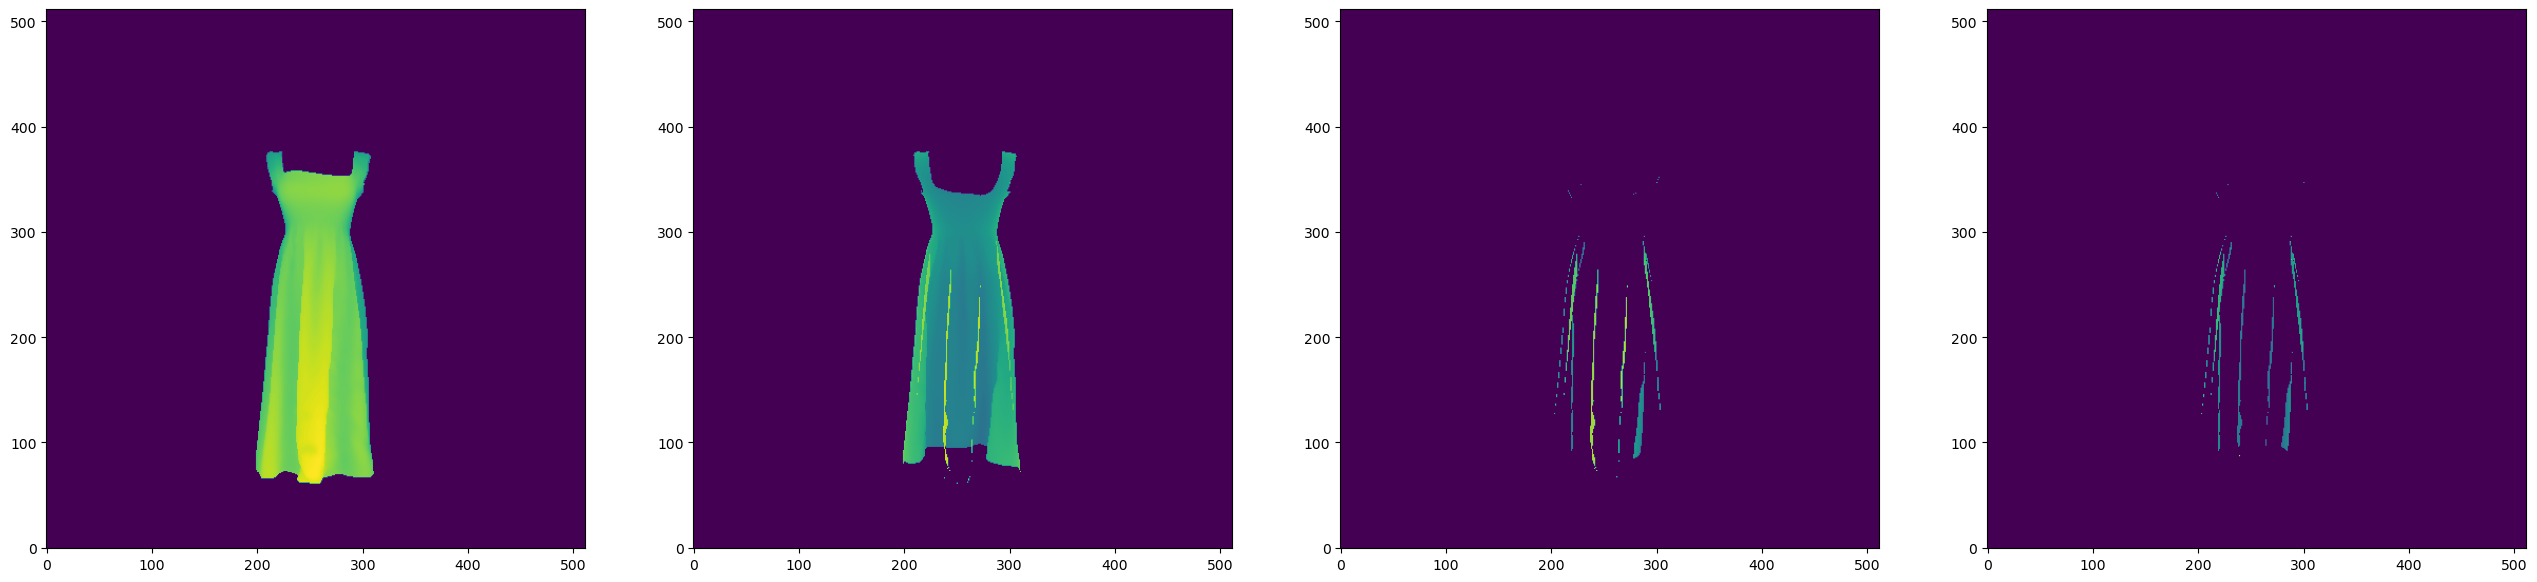

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


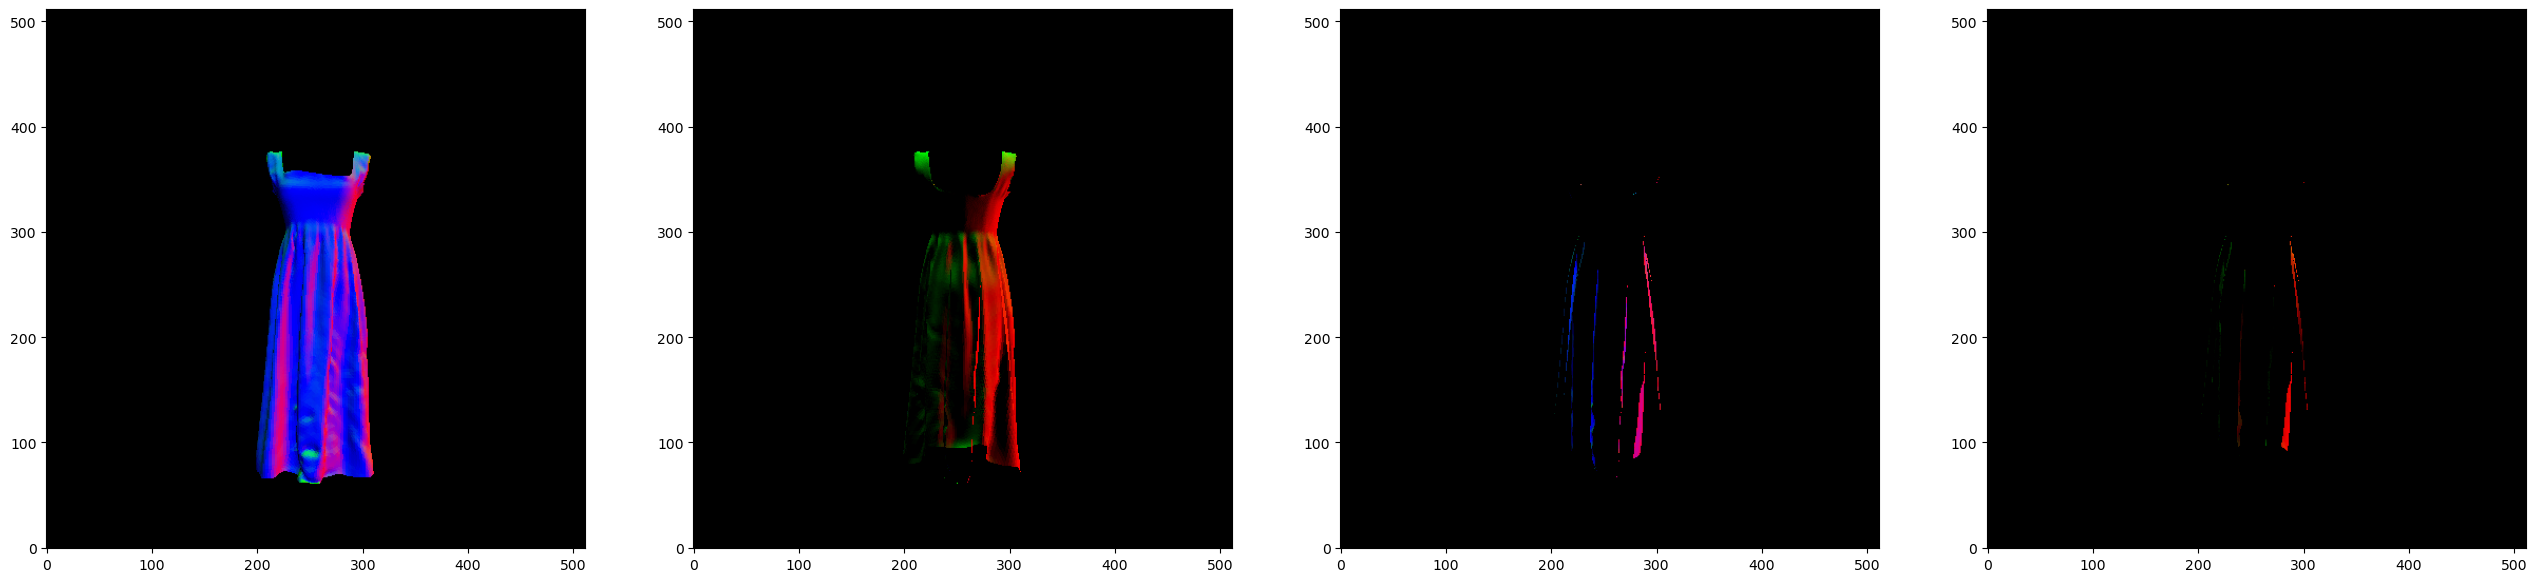

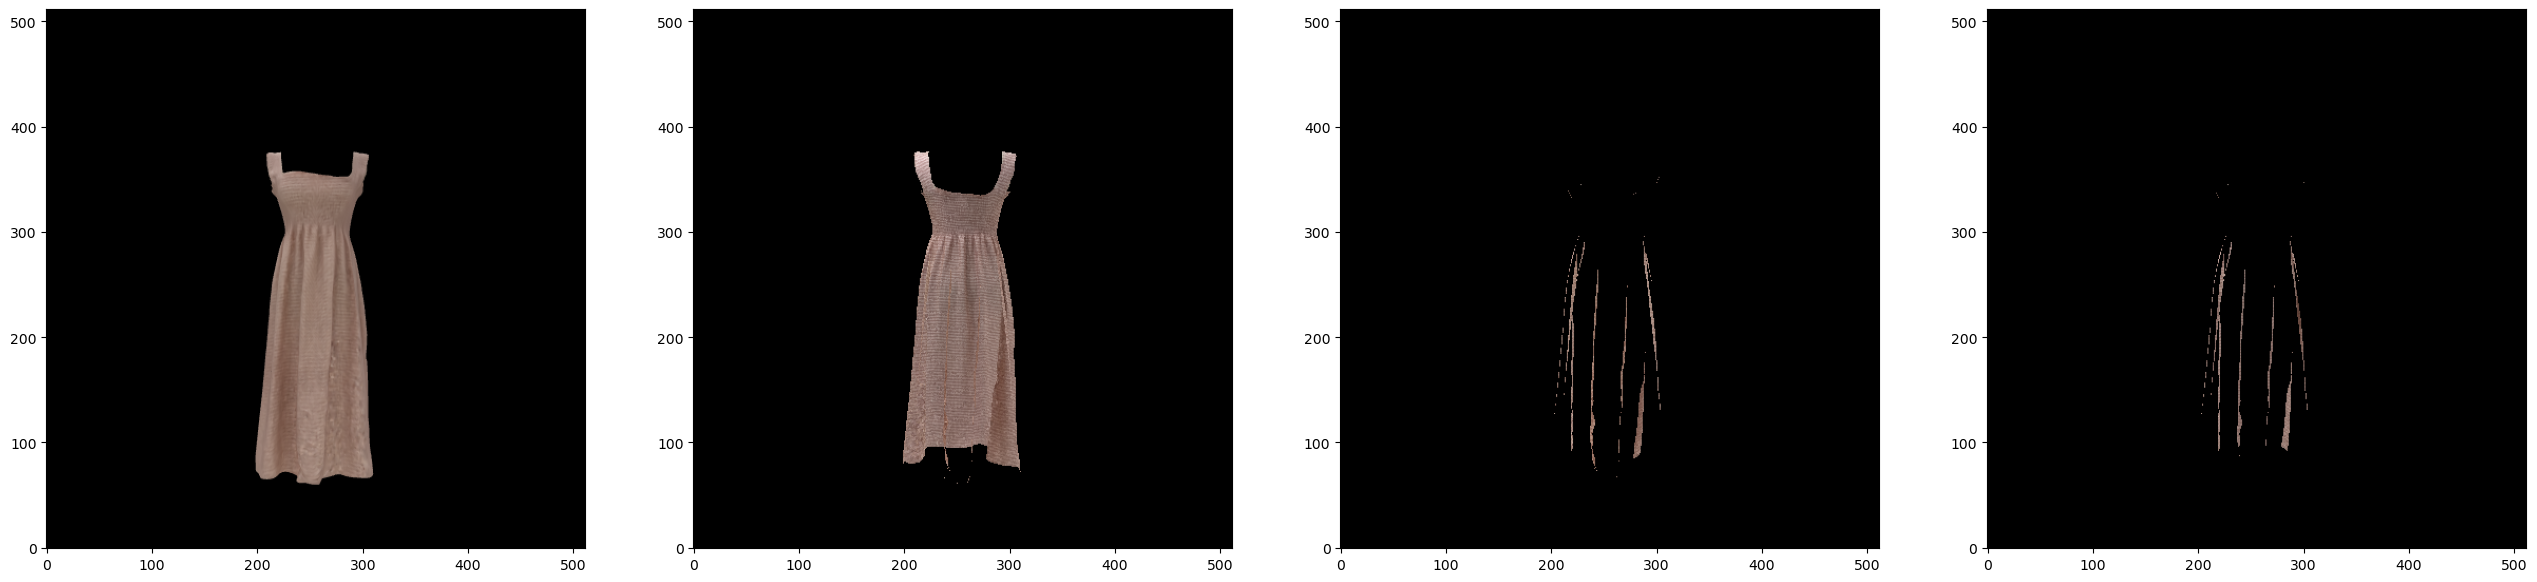

In [6]:
from matplotlib import pyplot as plt
from xcloth.utils import plot_3d, plot_depth

plot_depth(X_train[0, 0, 3:].cpu().numpy())
plot_depth(y_train["Depth"][0, 0].cpu().numpy().squeeze())
plot_3d(y_train["Norm"][0, 0].cpu().numpy())
plot_3d(np.concatenate([X_train[0, 0, :3].unsqueeze(0).cpu().numpy(), y_train["RGB"][0, 0].cpu().numpy()], axis=0))

tensor(0., device='cuda:0')

In [7]:
from xcloth.train import train_model
from xcloth.production import XCloth

xcloth = XCloth()
# xcloth(sample_in, sample_smpl)

train_model(
    xcloth,
    X_train,
    y_train,
    verbose=True,
    n_epoch=1000,
    reduction="mean",
    params_path="../../data/test_data/params.pt",
)

epoch 1: loss: [tensor(2.9931, device='cuda:0', grad_fn=<AddBackward0>)]
epoch 2: loss: [tensor(1.9725, device='cuda:0', grad_fn=<AddBackward0>)]
epoch 3: loss: [tensor(1.0996, device='cuda:0', grad_fn=<AddBackward0>)]
epoch 4: loss: [tensor(0.6334, device='cuda:0', grad_fn=<AddBackward0>)]
epoch 5: loss: [tensor(0.3865, device='cuda:0', grad_fn=<AddBackward0>)]
epoch 6: loss: [tensor(0.2725, device='cuda:0', grad_fn=<AddBackward0>)]
epoch 7: loss: [tensor(0.2187, device='cuda:0', grad_fn=<AddBackward0>)]
epoch 8: loss: [tensor(0.1921, device='cuda:0', grad_fn=<AddBackward0>)]
epoch 9: loss: [tensor(0.1778, device='cuda:0', grad_fn=<AddBackward0>)]
epoch 10: loss: [tensor(0.1691, device='cuda:0', grad_fn=<AddBackward0>)]
epoch 11: loss: [tensor(0.1631, device='cuda:0', grad_fn=<AddBackward0>)]
epoch 12: loss: [tensor(0.1581, device='cuda:0', grad_fn=<AddBackward0>)]
epoch 13: loss: [tensor(0.1534, device='cuda:0', grad_fn=<AddBackward0>)]
epoch 14: loss: [tensor(0.1484, device='cuda:0'

KeyboardInterrupt: 

In [ ]:
from xcloth.production import XCloth

model = XCloth()
model.load("../../data/test_data/params.pt")

with torch.no_grad():
    r = model(X_train[0, 0, :3], X_train[0, 0, 3:])

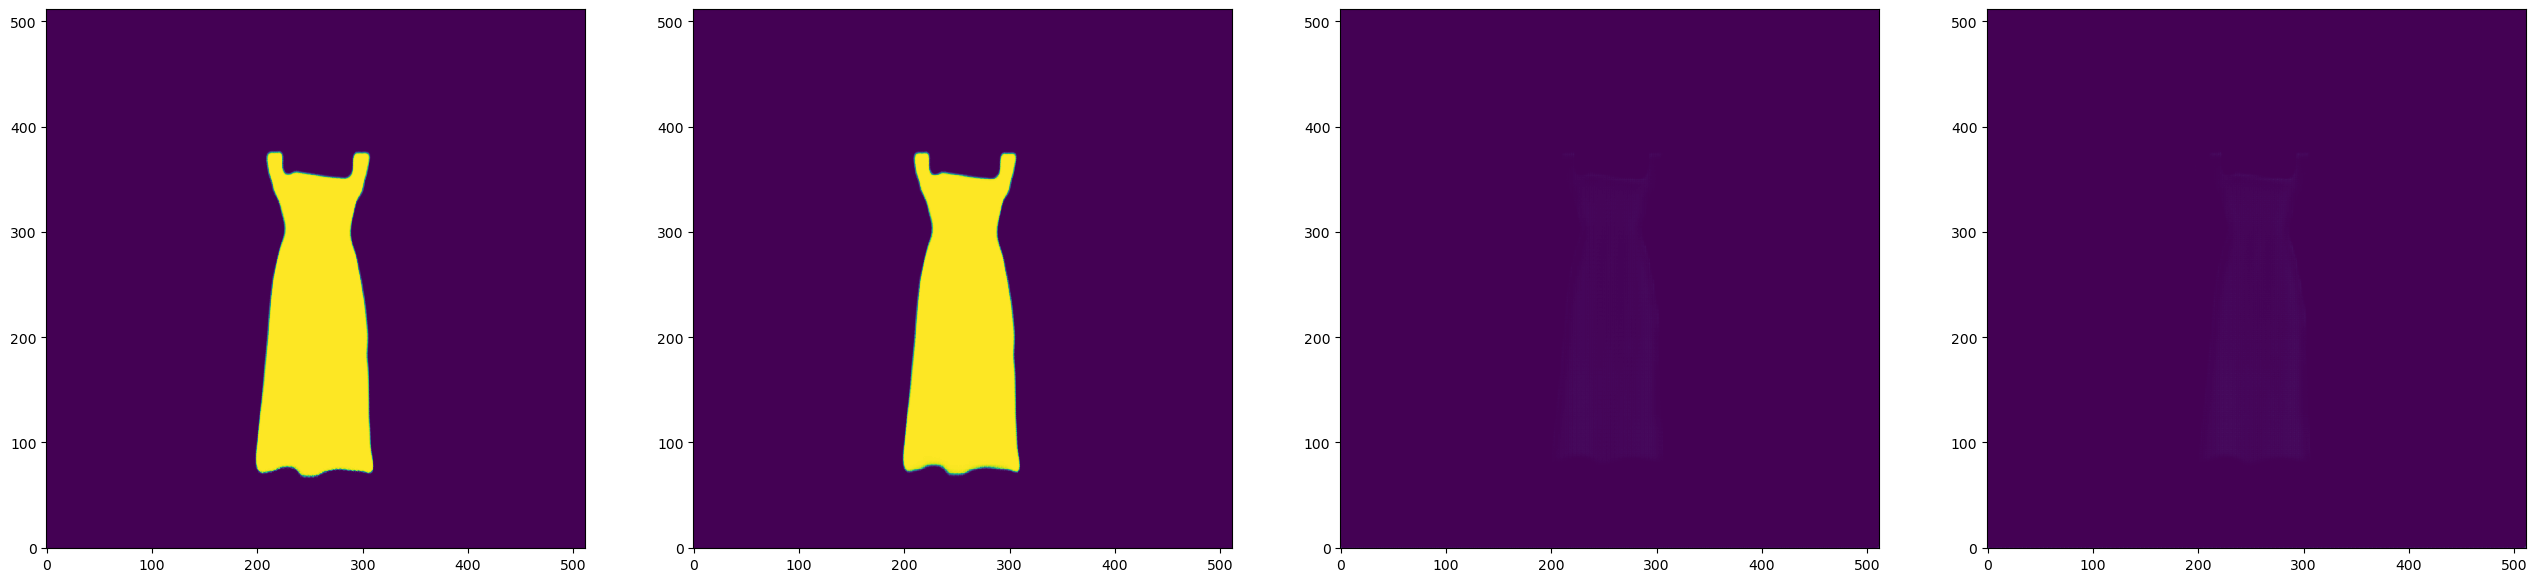

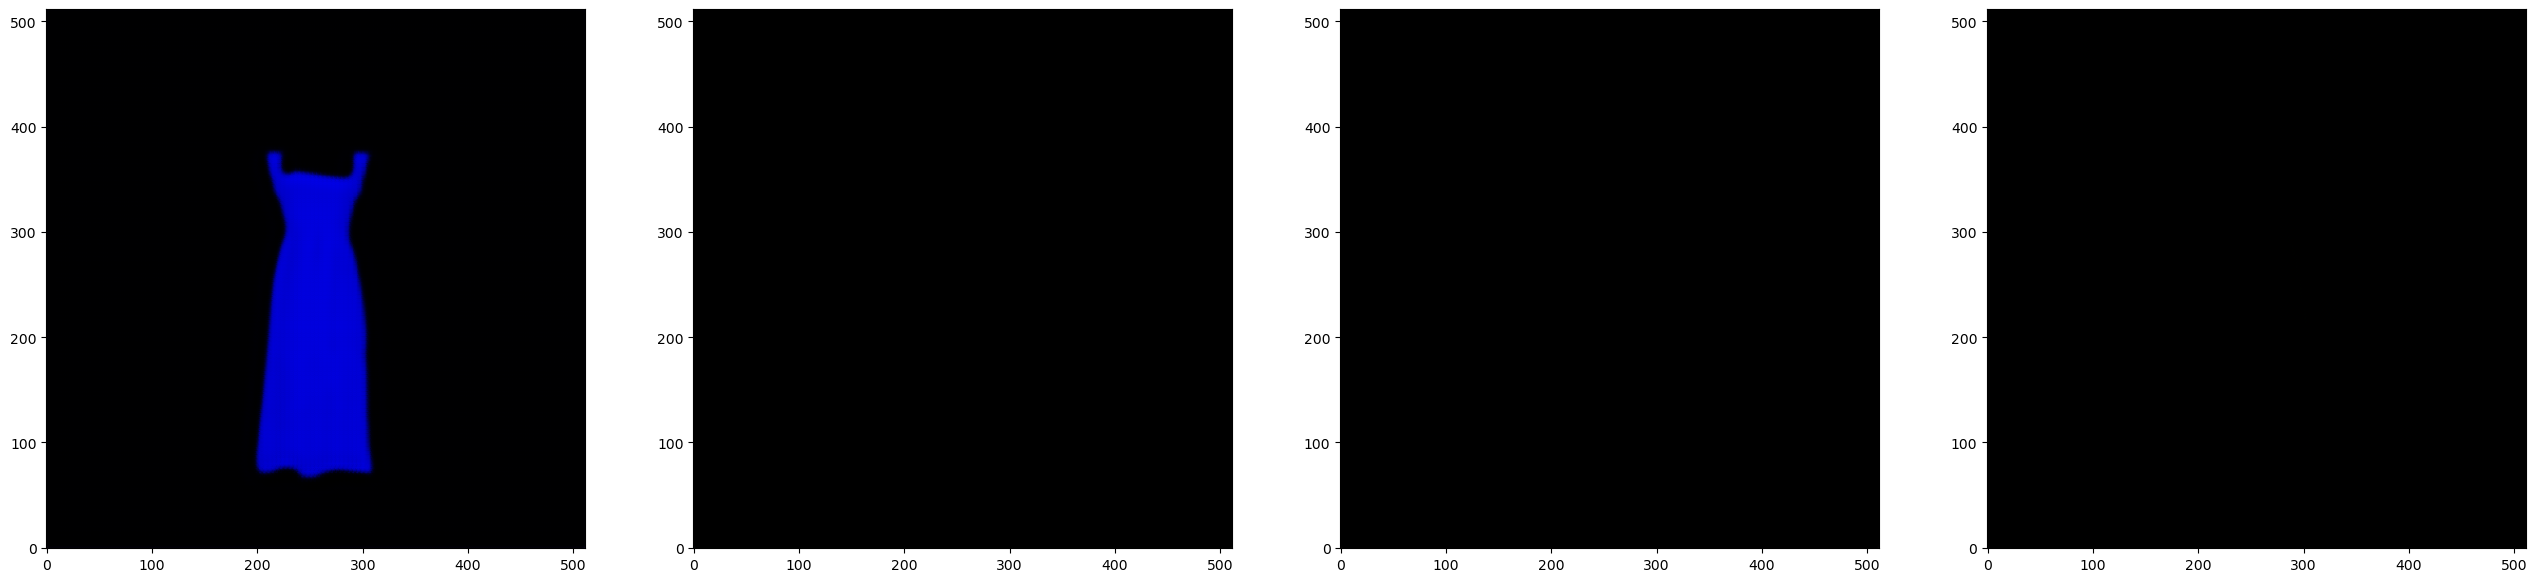

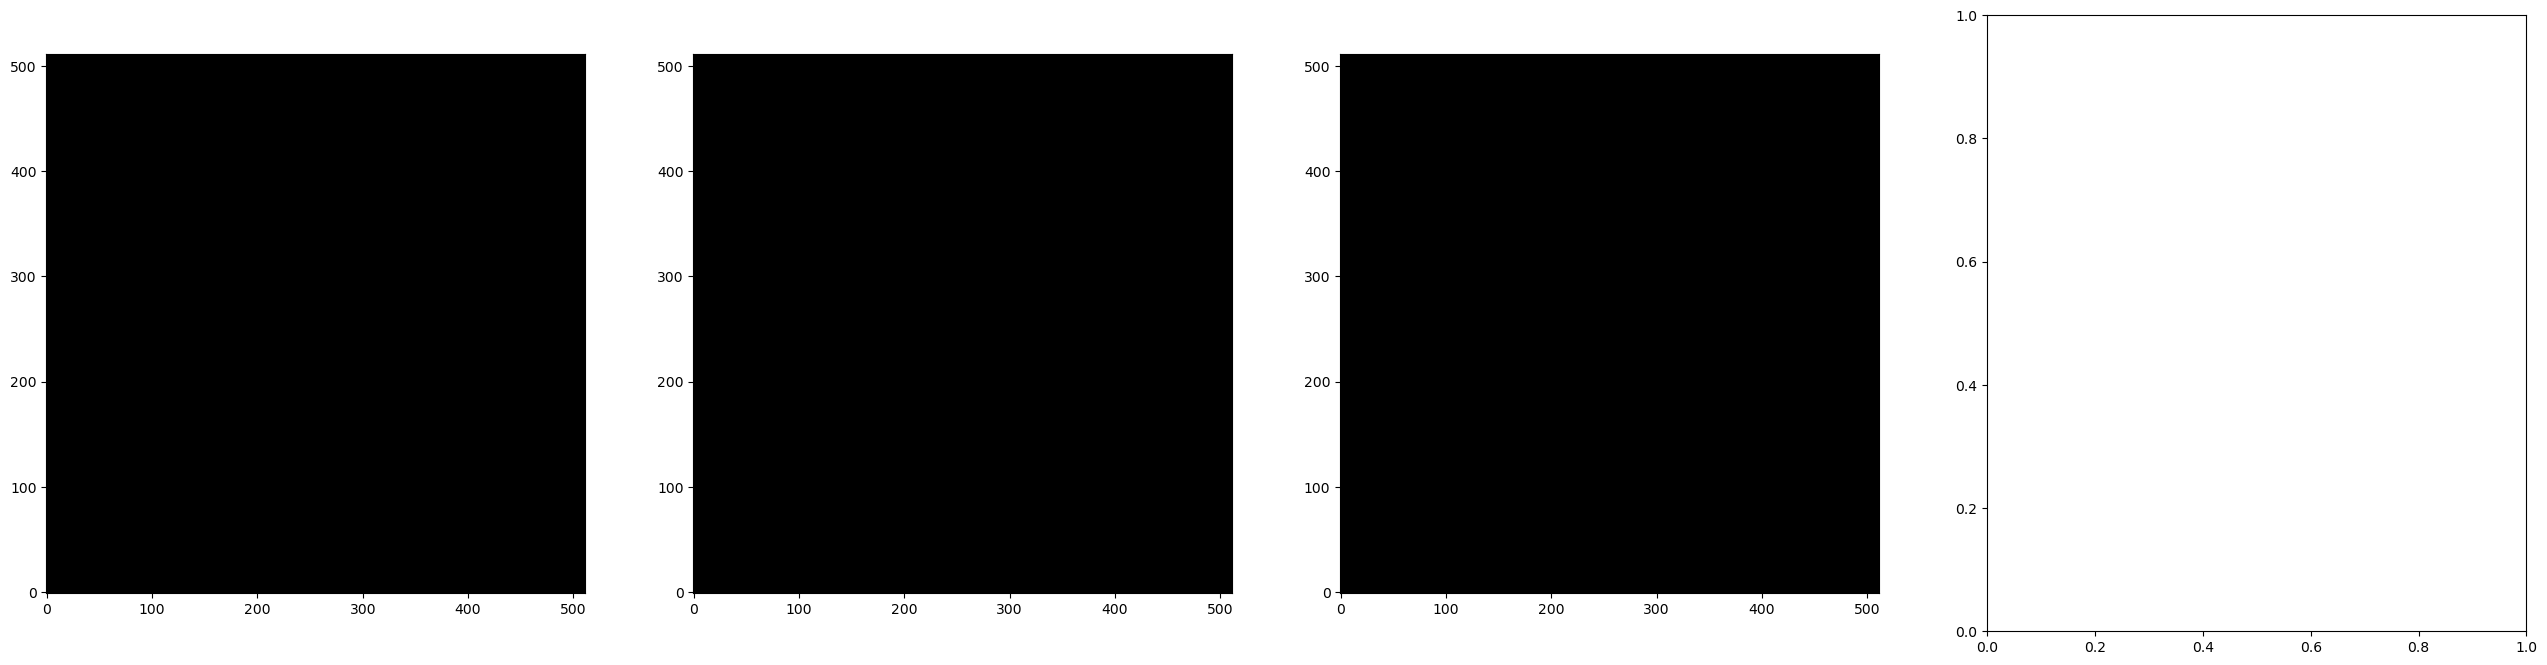

In [ ]:
tmp = r["Depth"][0].cpu().detach().numpy().squeeze() - .5
tmp[np.abs(tmp) < 5e-5] = 0
plot_depth(tmp)
plot_3d((r["Norm"][0].cpu().detach().numpy()))
plot_3d((r["RGB"][0].cpu().detach().numpy()))

In [ ]:
r["Depth"].min()

tensor(1.5843e-16, device='cuda:0')

In [ ]:
r["Depth"].max()

tensor(1.0000, device='cuda:0')

In [ ]:
r["Norm"].min()

tensor(4.8413e-08, device='cuda:0')

In [ ]:
y_train["Norm"].min()

tensor(-1.0000, device='cuda:0')

In [ ]:
import copy
import open3d as o3d

def create_idx_mat(size):
    return np.indices(size).swapaxes(0, 2).reshape((-1, 2))

def create_norm_coords(size, idx_mat=None):
    assert size[0] % 2 == 0 and size[1] % 2 == 0
    if idx_mat is None:
        idx_mat = create_idx_mat(size)
    else:
        idx_mat = copy.deepcopy(idx_mat)

    idx_mat[:, 0] -= size[0] // 2
    idx_mat[:, 1] -= size[1] // 2
    # idx_mat[:, 1] *= -1
    return idx_mat

def transform_coords_norm2real(size, coords, z, fov):
    """
    transform pixel coordinates `[[-pix_x/2, -pix_y/2], ..., [0, 0], ..., [pix_x/2, pix_y/2]]` to 3d world (x, y) coordinates.
    """
    real_coords = np.zeros_like(coords, dtype=np.float64)
    def __compute_pixsep(__s, __fov):
        """
        compute real distance between each pixel.
        """
        a = z*np.tan(__fov / 2)
        return __s / a / 2

    if type(fov) == tuple:
        assert len(size) == len(fov)
        sep = [__compute_pixsep(s, f) for s, f in zip(size, fov)]
    else:
        sep = __compute_pixsep(size[0], fov)
        sep = [sep for _ in range(len(size))]

    for dim in range(len(coords.shape)):
        real_coords[:, dim] = coords[:, dim] / sep[dim]

    return real_coords, sep

# reconstruct from depth
def reconstruct_from_depth(img_size, pm_depth, z, fov):
    pcd = []
    pix_coords = create_idx_mat(img_size)
    row, col = pix_coords[:, 1], pix_coords[:, 0]
    
    pix_coords_norm = create_norm_coords(img_size, idx_mat=pix_coords)
    real_coords, sep = transform_coords_norm2real(img_size, pix_coords_norm, z, fov)
    
    for depth in pm_depth:
        # flatten depth peelmaps
        f_d = depth[row, col].reshape(-1, 1)
        # reconstruct original (x, y) coordinates
        p = real_coords * (1 - f_d/z)
        p = np.hstack([p, f_d])[(f_d != 0).flatten()]
        pcd.append(p)

    return np.vstack(pcd)

pcd = reconstruct_from_depth((512, 512), tmp, 1, np.pi/3)
pcd = pcd[pcd[:, -1] != 0]

pcd = np.vstack(pcd)
reconstructed = o3d.geometry.PointCloud()
reconstructed.points = o3d.utility.Vector3dVector(pcd)
o3d.io.write_point_cloud(f"../no_git_test_data/pcd/reconstructed.ply", reconstructed)

True

In [ ]:
r["Img"].shape

torch.Size([1, 3, 512, 512])

In [ ]:
from xcloth.components.utils import GarmentModel3D
mesh = GarmentModel3D.from_tensor_dict(r, 1)

In [ ]:
mesh[0].mask = y_train["Depth"][0, 0, 0].squeeze().cpu().numpy()
mesh[0].mask = mesh[0].mask != 0
mesh[0].reconstruct(path="C:\\Users\\User\\CODE\\FYP\\models\\xcloth\\no_git_test_data\\pcd\\88-1_r")

In [ ]:
%reload_ext autoreload
%autoreload 2

mesh[0].to_obj(path="C:\\Users\\User\\CODE\\FYP\\models\\xcloth\\no_git_test_data\\pcd\\88-1_r\\reconstructed.obj", depth=15)

: 